In [1]:
### Import python modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ase

### Varibales form RuNNer UC
Bohr2Ang = 0.5291772109030   # CODATA 2018
Ang2Bohr = 1/Bohr2Ang
Eh2eV    = 27.211386245988   # CODATA 2018
eV2Eh    = 1/Eh2eV
f_conversion = eV2Eh/Ang2Bohr

Requirement already up-to-date: matplotlib in /opt/conda/lib/python3.8/site-packages (3.3.4)
Requirement already up-to-date: pandas in /opt/conda/lib/python3.8/site-packages (1.2.3)
Requirement already up-to-date: ase in /opt/conda/lib/python3.8/site-packages (3.21.1)


### Define the Plotting Stuff

In [2]:
def PlotData(dataset):
    '''
    Use this function to get an E/atom over V/atom curve of the workshop's
    data sets in the pandas data frame.
    '''
    fig1 = plt.figure(figsize=[51.2,28.8])
    # Define plot limits
    limits = [(7.5,25),(-4,-2.5)]
    # Define plot data
    atomic_volume = [dataset['atoms'][i].get_volume()/dataset['number_of_atoms'][i] for i in range(dataset.shape[0])]
    atomic_energy = dataset.energy/dataset.number_of_atoms
    # Count plot data
    counter = 0
    data_indices = []
    for point in range(len(atomic_volume)):
        if limits[0][0] <= atomic_volume[point] <= limits[0][1]:
            if limits[1][0] <= atomic_energy[point] <= limits[1][1]:
                counter += 1
                data_indices.append(point)
    print('Number of points in plot: {}'.format(counter))
    # Creating the plot E/atom vs. V/atom
    plt.text((limits[0][1]-limits[0][0])/2+limits[0][0], (limits[1][1]-limits[1][0])*0.95+limits[1][0], 'Number of points in plot: {}'.format(counter), fontsize = 30)
    plt.plot(atomic_volume, atomic_energy, '*')
    plt.xlabel('atomic volume in $\AA{}^3$', fontsize = 30)
    plt.ylabel('atomic energy in eV', fontsize = 30)
    plt.xticks([i for i in range(0,250,10)], fontsize = 30)
    plt.yticks([i for i in np.arange(0.0,-4.0,-0.5)], fontsize = 30)
    plt.xlim(limits[0])
    plt.ylim(limits[1])
    plt.grid()
    plt.show()
    return fig1

### Create a Python Class for a RuNNer Fit
- just reads the output of a certain fit
- defines some general quantaties like the RMSE values
- reads training and testing data energies and forces 

In [3]:
### Define RuNNer Fit Class
class RuNFit:
    '''
    This ia a class for a RuNNer fit.
    '''
    def __init__(self, dir_fit = None, epoch = 0):
        self.dir_fit = dir_fit
        self.epoch = epoch
        self.train2data, self.test2data = self.read_mode1()
        self.rmseEtr, self.rmseFtr, self.rmseEte, self.rmseFte, self.rmseEs, self.rmseFs = self.read_mode2()
        self.trainpoints, self.testpoints, self.trainforces, self.testforces = self.read_epoch()
        self.datapoints = self.reconstr_data()
    
    def read_mode1(self):
        dir_fit = self.dir_fit
        mode1_in = open(dir_fit +'/'+ 'mode1.out', 'r')
        train2data = {}
        test2data = {}
        for line_in in mode1_in:
            splitline = line_in.split()
            if len(splitline) >= 2 and splitline[1] == 'Point':
                if splitline[5] == 'training':
                    train2data[splitline[6]] = splitline[0]
                elif splitline[5] == 'testing':
                    test2data[splitline[6]] = splitline[0]
                else:
                    print('Problem with data!')
                    print(line_in)
                    exit()
        return train2data, test2data
    
    def read_mode2(self):
        '''
        Read RMSEs, usually in eV/atom an eV/bohr.
        '''
        dir_fit = self.dir_fit
        rmseEs = []
        rmseFs = []
        try:
            mode2_in = open(dir_fit +'/'+ 'fit.out', 'r')
        except:
            mode2_in = open(dir_fit +'/'+ 'mode2.out', 'r')
        for line_in in mode2_in:
            splitline = line_in.split()
            if len(splitline) == 0:
                continue
            elif splitline[0] == 'ENERGY':
                rmseEtr = float(splitline[2])
                rmseEte = float(splitline[3])
                rmseEs.append([rmseEtr, rmseEte])
            elif splitline[0] == 'FORCES':
                rmseFtr = float(splitline[2])/Bohr2Ang
                rmseFte = float(splitline[3])/Bohr2Ang
                rmseFs.append([rmseFtr, rmseFte])
            elif splitline[0] == 'OPTSHORT':
                rmseEtr = float(splitline[1])
                rmseFtr = float(splitline[3])/Bohr2Ang
                rmseEte = float(splitline[2])
                rmseFte = float(splitline[4])/Bohr2Ang
        rmseEs = np.array(rmseEs)
        rmseFs = np.array(rmseFs)
        return rmseEtr, rmseFtr, rmseEte, rmseFte, rmseEs, rmseFs

    def read_epoch(self):
        dir_fit = self.dir_fit
        epoch = self.epoch
        # Trainpoints
        trainpoints_file = dir_fit +'/'+ 'trainpoints.{:06d}.out'.format(epoch)
        trainpoints = np.loadtxt(trainpoints_file, dtype = 'float', skiprows = 1)
        trainpoints = pd.DataFrame(trainpoints, columns = ['Conf.', 'atoms',
                                                           'Ref. total energy(Ha)',
                                                           'NN total energy(Ha)',
                                                           'E(Ref.) - E(NN) (Ha/atom)'])
        
        # Testpoints
        testpoints_file = dir_fit +'/'+ 'testpoints.{:06d}.out'.format(epoch)
        testpoints = np.loadtxt(testpoints_file, dtype = 'float', skiprows = 1)
        testpoints = pd.DataFrame(testpoints, columns = ['Conf.', 'atoms',
                                                         'Ref. total energy(Ha)',
                                                         'NN total energy(Ha)',
                                                         'E(Ref.) - E(NN) (Ha/atom)'])

        # Trainforces
        trainforces_file = dir_fit +'/'+ 'trainforces.{:06d}.out'.format(epoch)
        trainforces = np.loadtxt(trainforces_file, dtype = 'float', skiprows = 1)
        trainforces = pd.DataFrame(trainforces, columns = ['Conf.', 'atom',
                                                           'Ref. Fx(Ha/Bohr)',
                                                           'Ref. Fy(Ha/Bohr)',
                                                           'Ref. Fz(Ha/Bohr)',
                                                           'NN Fx(Ha/Bohr)',
                                                           'NN Fy(Ha/Bohr)',
                                                           'NN Fz(Ha/Bohr)'])

        # Testforces
        testforces_file = dir_fit +'/'+ 'testforces.{:06d}.out'.format(epoch)
        testforces = np.loadtxt(testforces_file, dtype = 'float', skiprows = 1)
        testforces = pd.DataFrame(testforces, columns = ['Conf.', 'atom',
                                                         'Ref. Fx(Ha/Bohr)',
                                                         'Ref. Fy(Ha/Bohr)',
                                                         'Ref. Fz(Ha/Bohr)',
                                                         'NN Fx(Ha/Bohr)',
                                                         'NN Fy(Ha/Bohr)',
                                                         'NN Fz(Ha/Bohr)'])

        return trainpoints, testpoints, trainforces, testforces

    def reconstr_data(self):
        len_data_set = len(self.trainpoints) + len(self.testpoints)
        datapoints = [None] * len_data_set
        for point in range(len(self.trainpoints)):
            datapoints[int(self.train2data[str(point+1)])-1] = np.array(self.trainpoints.iloc[point])
        for point in range(len(self.testpoints)):
            datapoints[int(self.test2data[str(point+1)])-1] = np.array(self.testpoints.iloc[point])
        return pd.DataFrame(np.array(datapoints), columns = ['Conf.', 'atoms',
                                                           'Ref. total energy(Ha)',
                                                           'NN total energy(Ha)',
                                                           'E(Ref.) - E(NN) (Ha/atom)'])

    def plot_points(self):
        rmseE = self.rmseEtr
        trainpoints = self.trainpoints
        testpoints = self.testpoints
        
        #Atomic energy difference over the number
        fig1 = plt.figure('Energy Difference 1')
        fig1.suptitle('Energy Difference DFT vs. NNP')
        plt.plot(trainpoints['Conf.'],(trainpoints['Ref. total energy(Ha)']\
                                       - trainpoints['NN total energy(Ha)'])\
                                       / trainpoints['atoms'] * Eh2eV,
                 'r+', label='Trainpoints')
        plt.plot(testpoints['Conf.'] + len(trainpoints),(testpoints['Ref. total energy(Ha)']\
                                                         - testpoints['NN total energy(Ha)'])\
                                                         / testpoints['atoms']  * Eh2eV,
                 'g+', label='Testpoints')
        plt.xlabel('# of Structure')
        plt.ylabel('(E(DFT)-E(NNP))/atom in eV')
        rmse_line = np.array([[0, rmseE], [len(trainpoints)+len(testpoints), rmseE]])
        plt.plot(rmse_line[:,0], rmse_line[:,1]*2, 'b-', label='+-2RMSE')
        plt.plot(rmse_line[:,0], -rmse_line[:,1]*2, 'b-')
        plt.legend()

        #Atomic energy NNP over atomic energy DFT
        fig2 = plt.figure('Energy Difference 2')
        fig2.suptitle('Energy Difference DFT vs. NNP')
        plt.plot(trainpoints['Ref. total energy(Ha)'] / trainpoints['atoms'] * Eh2eV,
                 trainpoints['NN total energy(Ha)'] / trainpoints['atoms'] * Eh2eV,
                 'r+', label='Trainpoints')
        plt.plot(testpoints['Ref. total energy(Ha)'] / testpoints['atoms'] * Eh2eV,
                 testpoints['NN total energy(Ha)'] / testpoints['atoms'] * Eh2eV,
                 'g+', label='Testpoints')
        min_Eatom_pos = trainpoints['Ref. total energy(Ha)'].argmin()
        max_Eatom_pos = trainpoints['Ref. total energy(Ha)'].argmax()
        ref_line = np.array([[trainpoints['Ref. total energy(Ha)'][min_Eatom_pos] /
                              trainpoints['atoms'][min_Eatom_pos],
                              trainpoints['Ref. total energy(Ha)'][min_Eatom_pos] /
                              trainpoints['atoms'][min_Eatom_pos]],
                             [trainpoints['Ref. total energy(Ha)'][max_Eatom_pos] /
                              trainpoints['atoms'][max_Eatom_pos],
                              trainpoints['Ref. total energy(Ha)'][max_Eatom_pos] /
                              trainpoints['atoms'][max_Eatom_pos]]])
        plt.plot(ref_line[:,0] * Eh2eV, ref_line[:,1] * Eh2eV, 'b-', label='Ref.')
        plt.xlabel('E(DFT)/atom in eV')
        plt.ylabel('E(NNP)/atom in eV')
        plt.legend()
        
        #Energy difference over atomic energy DFT
        fig3 = plt.figure('')
        fig3. suptitle('')
        plt.plot(trainpoints['Ref. total energy(Ha)'] / trainpoints['atoms'] * Eh2eV,
                 trainpoints['E(Ref.) - E(NN) (Ha/atom)'] * Eh2eV,
                 'r+', label='Trainpoints')
        plt.plot(testpoints['Ref. total energy(Ha)'] / testpoints['atoms'] * Eh2eV,
                 testpoints['E(Ref.) - E(NN) (Ha/atom)'] * Eh2eV,
                 'g+', label='Testpoints')
        min_Eatom_pos = trainpoints['Ref. total energy(Ha)'].argmin()
        max_Eatom_pos = trainpoints['Ref. total energy(Ha)'].argmax()
        rmse_line = np.array([[trainpoints['Ref. total energy(Ha)'][min_Eatom_pos] /
                               trainpoints['atoms'][min_Eatom_pos], rmseE],
                              [trainpoints['Ref. total energy(Ha)'][max_Eatom_pos] /
                              trainpoints['atoms'][max_Eatom_pos], rmseE]])
        plt.plot(rmse_line[:,0] * Eh2eV, rmse_line[:,1]*2, 'b-', label='+-2RMSE')
        plt.plot(rmse_line[:,0] * Eh2eV, -rmse_line[:,1]*2, 'b-')
        plt.xlabel('E(DFT)/atom in eV')
        plt.ylabel('(E(DFT)-E(NNP))/atom in eV')
        plt.legend()
        
        return fig1, fig2, fig3

    def plot_forces(self):
        rmseF = self.rmseFtr
        trainpoints = self.trainpoints
        testpoints = self.testpoints
        trainforces = self.trainforces
        testforces = self.testforces
        fig1 = plt.figure('Force Difference 1')
        fig1.suptitle('Force Difference DFT vs. NNP')
        plt.plot(trainforces['Conf.'], (trainforces['Ref. Fx(Ha/Bohr)'] - trainforces['NN Fx(Ha/Bohr)']) * Eh2eV / Bohr2Ang, 'r1', label='TrainFx')
        plt.plot(trainforces['Conf.'], (trainforces['Ref. Fy(Ha/Bohr)'] - trainforces['NN Fy(Ha/Bohr)']) * Eh2eV / Bohr2Ang, 'r2', label='TrainFy')
        plt.plot(trainforces['Conf.'], (trainforces['Ref. Fz(Ha/Bohr)'] - trainforces['NN Fz(Ha/Bohr)']) * Eh2eV / Bohr2Ang, 'r3', label='TrainFz')
        plt.plot(testforces['Conf.'] + len(trainpoints), (testforces['Ref. Fx(Ha/Bohr)'] - testforces['NN Fx(Ha/Bohr)']) * Eh2eV / Bohr2Ang, 'g1', label='TestFx')
        plt.plot(testforces['Conf.'] + len(trainpoints), (testforces['Ref. Fy(Ha/Bohr)'] - testforces['NN Fy(Ha/Bohr)']) * Eh2eV / Bohr2Ang, 'g2', label='TestFy')
        plt.plot(testforces['Conf.'] + len(trainpoints), (testforces['Ref. Fz(Ha/Bohr)'] - testforces['NN Fz(Ha/Bohr)']) * Eh2eV / Bohr2Ang, 'g3', label='TestFz')
        plt.xlabel('# of Structure')
        plt.ylabel('F(DFT)-F(NNP) in eV/Ang')
        rmse_line = np.array([[0, rmseF / Bohr2Ang], [len(trainpoints) + len(testpoints), rmseF / Bohr2Ang]])
        plt.plot(rmse_line[:,0], rmse_line[:,1]*2, 'b-', label='+-2RMSE')
        plt.plot(rmse_line[:,0], -rmse_line[:,1]*2, 'b-')
        plt.legend(ncol = 3)

        fig2 = plt.figure('Force Difference 2')
        fig2.suptitle('Force Difference DFT vs. NNP')
        plt.plot(trainforces['Ref. Fx(Ha/Bohr)'] * Eh2eV / Bohr2Ang, trainforces['NN Fx(Ha/Bohr)'] * Eh2eV / Bohr2Ang, 'r1', label='TrainFx')
        plt.plot(trainforces['Ref. Fy(Ha/Bohr)'] * Eh2eV / Bohr2Ang, trainforces['NN Fy(Ha/Bohr)'] * Eh2eV / Bohr2Ang, 'r2', label='TrainFy')
        plt.plot(trainforces['Ref. Fz(Ha/Bohr)'] * Eh2eV / Bohr2Ang, trainforces['NN Fz(Ha/Bohr)'] * Eh2eV / Bohr2Ang, 'r3', label='TrainFz')
        plt.plot(testforces['Ref. Fx(Ha/Bohr)'] * Eh2eV / Bohr2Ang, testforces['Ref. Fx(Ha/Bohr)'] * Eh2eV / Bohr2Ang, 'g1', label='TestFx')
        plt.plot(testforces['Ref. Fy(Ha/Bohr)'] * Eh2eV / Bohr2Ang, testforces['Ref. Fy(Ha/Bohr)'] * Eh2eV / Bohr2Ang, 'g2', label='TestFy')
        plt.plot(testforces['Ref. Fz(Ha/Bohr)'] * Eh2eV / Bohr2Ang, testforces['Ref. Fz(Ha/Bohr)'] * Eh2eV / Bohr2Ang, 'g3', label='TestFz')
        min_FXYZatom = trainforces[['Ref. Fx(Ha/Bohr)', 'Ref. Fy(Ha/Bohr)', 'Ref. Fz(Ha/Bohr)']].min().min()
        max_FXYZatom = trainforces[['Ref. Fx(Ha/Bohr)', 'Ref. Fy(Ha/Bohr)', 'Ref. Fz(Ha/Bohr)']].max().max()
        ref_line = np.array([[min_FXYZatom, min_FXYZatom],
                             [max_FXYZatom, max_FXYZatom]])
        plt.plot(ref_line[:,0] * Eh2eV / Bohr2Ang, ref_line[:,1] * Eh2eV / Bohr2Ang, 'b-', label='Ref.')
        plt.xlabel('F(DFT) in eV/Ang')
        plt.ylabel('F(NNP) in eV/Ang')
        plt.legend(ncol = 3)

        fig3 = plt.figure('Force Difference 3')
        fig3.suptitle('Force Difference DFT vs. NNP')
        plt.plot(trainforces['Ref. Fx(Ha/Bohr)'] * Eh2eV / Bohr2Ang, (trainforces['Ref. Fx(Ha/Bohr)'] - trainforces['NN Fx(Ha/Bohr)']) * Eh2eV / Bohr2Ang, 'r1', label='TrainFx')
        plt.plot(trainforces['Ref. Fy(Ha/Bohr)'] * Eh2eV / Bohr2Ang, (trainforces['Ref. Fy(Ha/Bohr)'] - trainforces['NN Fy(Ha/Bohr)']) * Eh2eV / Bohr2Ang, 'r2', label='TrainFy')
        plt.plot(trainforces['Ref. Fz(Ha/Bohr)'] * Eh2eV / Bohr2Ang, (trainforces['Ref. Fz(Ha/Bohr)'] - trainforces['NN Fz(Ha/Bohr)']) * Eh2eV / Bohr2Ang, 'r3', label='TrainFz')
        plt.plot(testforces['Ref. Fx(Ha/Bohr)'] * Eh2eV / Bohr2Ang, (testforces['Ref. Fx(Ha/Bohr)'] - testforces['NN Fx(Ha/Bohr)']) * Eh2eV / Bohr2Ang, 'g1', label='TestFx')
        plt.plot(testforces['Ref. Fy(Ha/Bohr)'] * Eh2eV / Bohr2Ang, (testforces['Ref. Fy(Ha/Bohr)'] - testforces['NN Fy(Ha/Bohr)']) * Eh2eV / Bohr2Ang, 'g2', label='TestFy')
        plt.plot(testforces['Ref. Fz(Ha/Bohr)'] * Eh2eV / Bohr2Ang, (testforces['Ref. Fz(Ha/Bohr)'] - testforces['NN Fz(Ha/Bohr)']) * Eh2eV / Bohr2Ang, 'g3', label='TestFz')
        plt.xlabel('F(DFT) in eV/Ang')
        plt.ylabel('$\Delta F(NNP)$ in $\mathrm{eV}\,\mathrm{\AA{}}^{-1}$')
        min_FXYZatom = trainforces[['Ref. Fx(Ha/Bohr)', 'Ref. Fy(Ha/Bohr)', 'Ref. Fz(Ha/Bohr)']].min().min()
        max_FXYZatom = trainforces[['Ref. Fx(Ha/Bohr)', 'Ref. Fy(Ha/Bohr)', 'Ref. Fz(Ha/Bohr)']].max().max()
        rmse_line = np.array([[min_FXYZatom, rmseF],
                             [max_FXYZatom, rmseF]])
        plt.plot(rmse_line[:,0] * Eh2eV / Bohr2Ang, rmse_line[:,1] * 2 / Bohr2Ang, 'b-', label='+-2RMSE')
        plt.plot(rmse_line[:,0] * Eh2eV / Bohr2Ang, -rmse_line[:,1] * 2 / Bohr2Ang, 'b-')
        plt.legend(ncol = 3)
        return fig1, fig2, fig3

    def plot_rmse(self):
        rmseEs = self.rmseEs
        rmseFs = self.rmseFs
        fig1 = plt.figure('RMSEs over Epochs')
        fig1.suptitle('')
        plt.plot(rmseEs[:,0], 'r-', label='RMSE Etr')
        plt.plot(rmseEs[:,1], 'r:', label='RMSE Ete')
        plt.plot(rmseFs[:,0], 'g-', label='RMSE Ftr')
        plt.plot(rmseFs[:,1], 'g:', label='RMSE Fte')
        plt.xlabel('# epoch')
        plt.ylabel('RMSE in eV and eV/Ang')
        plt.legend()
        return fig1

    def plot_data(self):
        '''
        Plot of pandas dataset!
        '''
        dataset = self.RuNNer2data()
        fig1 = plt.figure(figsize=[51.2,28.8])
        # Define plot limits
        limits = [(7.5,25),(-4,-2.5)]
        # Define plot data
        atomic_volume = [dataset['atoms'][i].get_volume()/dataset['number_of_atoms'][i] for i in range(dataset.shape[0])]
        atomic_energy = dataset.energy/dataset.number_of_atoms
        # Count plot data
        counter = 0
        data_indices = []
        for point in range(len(atomic_volume)):
            if limits[0][0] <= atomic_volume[point] <= limits[0][1]:
                if limits[1][0] <= atomic_energy[point] <= limits[1][1]:
                    counter += 1
                    data_indices.append(point)
        print('Number of points in plot: {}'.format(counter))
        # Creating the plot E/atom vs. V/atom
        plt.text((limits[0][1]-limits[0][0])/2+limits[0][0], (limits[1][1]-limits[1][0])*0.95+limits[1][0], 'Number of points in plot: {}'.format(counter), fontsize = 30)
        plt.plot(atomic_volume, atomic_energy, '*')
        plt.xlabel('atomic volume in $\AA{}^3$', fontsize = 30)
        plt.ylabel('atomic energy in eV', fontsize = 30)
        plt.xticks([i for i in range(0,250,10)], fontsize = 30)
        plt.yticks([i for i in np.arange(0.0,-4.0,-0.5)], fontsize = 30)
        plt.xlim(limits[0])
        plt.ylim(limits[1])
        plt.grid()
        return fig1

        n2, bins2, patches2 = plt.hist(dataset.energy/dataset.number_of_atoms, 20)
        plt.xlabel('atomic energy in eV')
        plt.ylabel('amount of structures')

    def NN_over_data(self):
        '''
        NN predictions over pandas dataset!
        '''
        dataset = self.RuNNer2data()
        datapoints = self.datapoints
        fig1 = plt.figure(figsize=[25.6,14.4])
        # Define plot limits
        limits = [(7.5,25),(-4,-2.5)]
        # Define plot data
        atomic_volume = [dataset['atoms'][i].get_volume()/dataset['number_of_atoms'][i] for i in range(dataset.shape[0])]
        atomic_energy = dataset.energy/dataset.number_of_atoms
        # Creating the plot E/atom vs. V/atom
        plt.plot(atomic_volume, atomic_energy, '+', label='ref')
        plt.plot(atomic_volume, datapoints['NN total energy(Ha)']/self.datapoints['atoms'] * Eh2eV, 'x', label='NN')
        plt.plot(atomic_volume, datapoints['E(Ref.) - E(NN) (Ha/atom)'] * Eh2eV - 3.8, '+', label='ref-NN')
        plt.plot(limits[0], [-3.8, -3.8], color='black', label='ref. line')
        plt.xlabel('atomic volume in $\AA{}^3$', fontsize = 30)
        plt.ylabel('atomic energy in eV', fontsize = 30)
        plt.xticks([i for i in range(0,250,10)], fontsize = 30)
        plt.yticks([i for i in np.arange(0.0,-4.0,-0.5)], fontsize = 30)
        plt.xlim(limits[0])
        plt.ylim(limits[1])
        plt.grid()
        plt.legend()
        return fig1

    def RuNNer2data(self):
        '''
        Reading RuNNer's input.data file and create a pandas data frame as used for/in the workshop
        '''
        RuNNer_input = open(self.dir_fit +'/'+ 'input.data', 'r')
        atom_counter = 0
        found_data_point = False
        lattice_constants = []
        atomic_positions = []
        elements = []
        forces = []
        pandas_data_frame = []
        for line in RuNNer_input:
            if len(line.strip().split()) == 0:
                continue
            elif line.strip().split()[0] == 'begin':
                found_data_point = True
            elif found_data_point:
                if line.strip().split()[0] == 'end':
                    atomic_positions = np.array(atomic_positions, dtype = float) * Bohr2Ang
                    elements = ''.join(elements)
                    forces = np.array(forces, dtype = 'float') * 1/f_conversion
                    pandas_data_frame.append([len(pandas_data_frame)+1, ase.Atoms(elements, positions = atomic_positions, cell = lattice_constants, pbc = True), data_point_energy, forces, atom_counter])
                    # Here add to pandas data frame ...
                    #print(atomic_positions, elements, forces, lattice_constants)
                    found_data_point = False
                    atom_counter = 0
                    lattice_constants = []
                    atomic_positions = []
                    elements = []
                    forces = []
                elif line.strip().split()[0] == 'energy':
                    data_point_energy = float(line.strip().split()[1]) * Eh2eV
                elif line.strip().split()[0] == 'charge':
                    data_point_charge = float(line.strip().split()[1])
                elif line.strip().split()[0] == 'atom':
                    atom_counter += 1
                    atomic_positions.append([line.strip().split()[1], line.strip().split()[2], line.strip().split()[3]])
                    elements.append(line.strip().split()[4])
                    forces.append([line.strip().split()[7], line.strip().split()[8], line.strip().split()[9]])
                elif line.strip().split()[0] == 'lattice':
                    lattice_constants.append((float(line.strip().split()[1]) * Bohr2Ang, float(line.strip().split()[2]) * Bohr2Ang, float(line.strip().split()[3]) * Bohr2Ang))
                elif line.strip().split()[0] == 'comment':
                    pass
        RuNNer_input.close()
        return pd.DataFrame(np.array(pandas_data_frame), columns = ['name', 'atoms', 'energy', 'forces', 'number_of_atoms'])

    def plot_all(self):
        '''
        '''
        figRMSE = self.plot_rmse()
        figE1, figE2, figE3 = self.plot_points()
        figF1, figF2, figF3 = self.plot_forces()
        return figRMSE, figE1, figE2, figE3, figF1, figF2, figF3

### Symmetry Functions (SF)
Define functions for the SF

In [4]:
def radialSF(distance, eta=0.0, shift=0.0, cutoff=12.0, type_fct=2, type_cutoff=1, inner_cutoff=0.0):
    '''
    '''
    d = distance
    e = eta
    s = shift
    t = type_fct
    c = cutoff
    tc = type_cutoff
    ic = inner_cutoff
    if t == 0:
        pass
    elif t == 2:
        radial_part = np.exp(-e * (d - s)**2) 
        cutoff_part = cutofffct(d, c, tc, ic)
    else:
        pass
    return radial_part * cutoff_part, radial_part, cutoff_part

def angularSF(angle123, distance12, distance13, distance23, eta=0.0, Lambda=1.0, zeta=1.0, cutoff=12.0, type_fct=3, type_cutoff=1, inner_cutoff=0.0):
    '''
    '''
    a123 = angle123/360 * (np.pi * 2)
    d12 = distance12
    d13 = distance13
    d23 = distance23
    e = eta
    z = zeta
    l = Lambda
    t = type_fct
    c = cutoff
    tc = type_cutoff
    ic = inner_cutoff
    if t == 3:
        angular_part = 2**(1 - z) * (1 + l * np.cos(a123))**z 
        radial_part = np.exp(-e * (d12**2 + d13**2 + d23**2))
        cutoff_part = cutofffct(d12, c, tc, ic) * cutofffct(d13, c, tc, ic) * cutofffct(d23, c, tc, ic)
    else:
        pass
    return angular_part * radial_part * cutoff_part, angular_part, radial_part, cutoff_part

def cutofffct(distance, cutoff=12.0, type_fct=1, inner_cutoff=0.0):
    '''
    '''
    d = distance
    c = cutoff
    t = type_fct
    ic = inner_cutoff
    x = (d - ic) / (c-ic)
    if t == 0:
        pass
    elif t == 1:
        if d < ic:
            return 1.0
        elif ic <= d <= c:
            return 0.5 * (np.cos(np.pi * x) + 1)
        elif c < d:
            return 0.0
    else:
        pass

### Compare two NNPs

In [5]:
def DiffNN(nnp1, nnp2):
    '''
    As input needs to RuNNer Fits of the RuNFit class.
    '''
    # Check if nnp objects belong to RuNFit class
    if isinstance(nnp1, RuNFit):
        if isinstance(nnp2, RuNFit):
            pass
        else:
            print('Fit nnp2 is not an obejct of RuNFit class!')
    else:
        print('Fit nnp1 is not an obejct of RuNFit class!')
    # Check if nnp objects show at least the same amount of train- + testpoints
    if len(nnp1.trainpoints) + len(nnp1.testpoints) == len(nnp2.trainpoints) + len(nnp2.testpoints):
        pass
    else:
        print('Objects do not have the same data set size!')
        exit()
    fig1 = plt.figure('NNP Energy Difference')
    fig1.suptitle('Energy Difference NNP1 vs. NNP2')
    plt.plot(nnp1.datapoints[:,3]/nnp1.datapoints[:,4],nnp2.datapoints[:,3]/nnp2.datapoints[:,4], 'r+', label='Energy')
    x = np.array([nnp1.datapoints[(nnp1.datapoints[:,3]/nnp1.datapoints[:,4]).argsort(axis=0)][0][3]/nnp1.datapoints[(nnp1.datapoints[:,3]/nnp1.datapoints[:,4]).argsort(axis=0)][0][4], nnp1.datapoints[(nnp1.datapoints[:,3]/nnp1.datapoints[:,4]).argsort(axis=0)][-1][3]/nnp1.datapoints[(nnp1.datapoints[:,3]/nnp1.datapoints[:,4]).argsort(axis=0)][-1][4]])
    plt.plot(x,x, 'b-', label='Reference Line')
    plt.xlabel('$\Delta$E(NNP2)/atom in eV')
    plt.ylabel('$\Delta$E(NNP1)/atom in eV')
    plt.legend()
    #return fig1

# The RuNNer Workflow
- Add stuff for general NNP
- expression of energy
- general concept

## Getting the First Data Set

- how to get a first data set (several ways like: small random atomic displacements, thermal displaceme)
- "detailed" look at data distribution


Number of points in plot: 8073


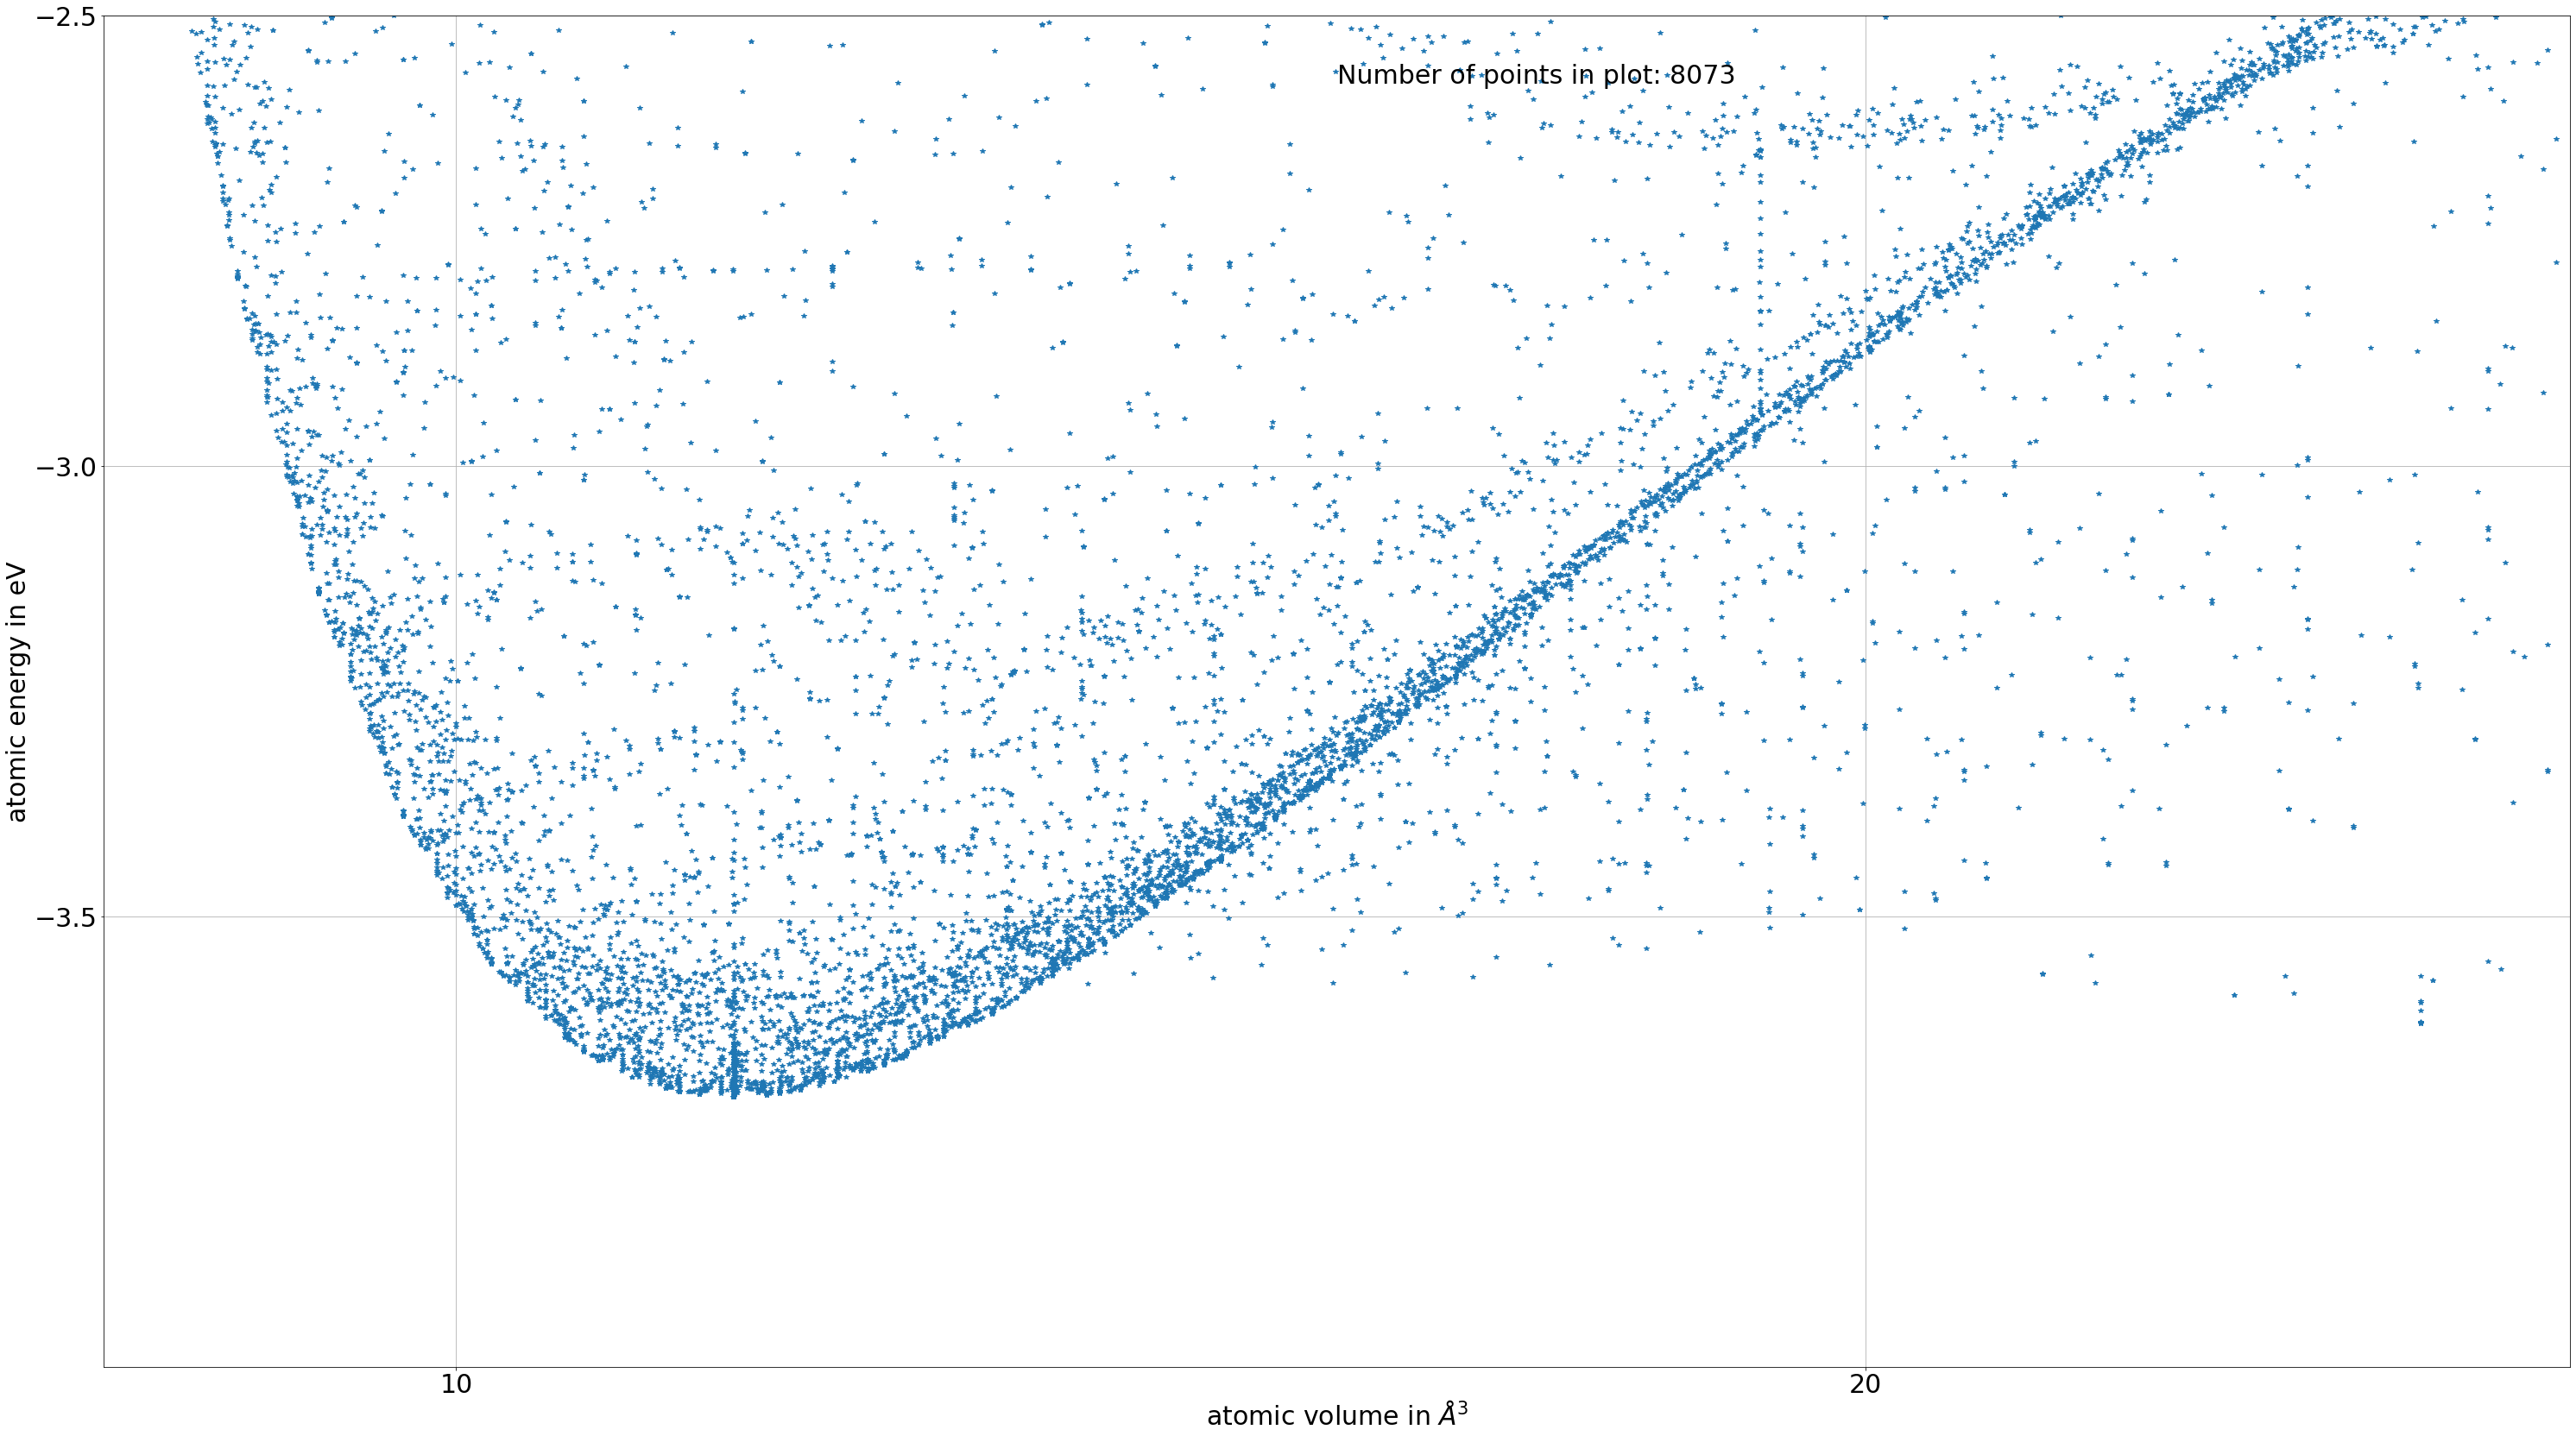

In [6]:
# Read in workshop's data set in pandas data frame
data = pd.read_pickle('Cu_df4_2.5eV_25A3_8K.pckl.gzip', compression='gzip')
fig1 = PlotData(data)

## RuNNer Mode 1
- Calculation of symmetry function values
- splitting of data set in train and test data set
- show mode 1 input (at the end of mode1 part)
- include pyiron-RuNNer

### Definition of the Symmetry Functions
- two types of symmetry functions (angular and radial)
- radial SF defined by shortest distance in data set with equivalent distribution of turning points
- number of symmetry functions depend on number of elements (roughly 5 radial SF and 8 angular SF per element combination)
- run RuNNer mode1 to calculate the SF vectors
- run a few fits with different random seeds to avoid a bad splitting of data

#### The Symmetry Functions (SF)
- What do they do?
- How do they do it?
- Why no cartesian coords?

### The Cutoff Function
- Why Do we need it?
- What does it look like?


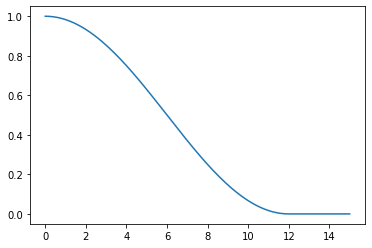

In [7]:
distances = np.arange(0,15.1,0.1)
cfct = np.array([cutofffct(i) for i in distances])
plt.plot(distances, cfct)

### The Radial Symmetry Functions

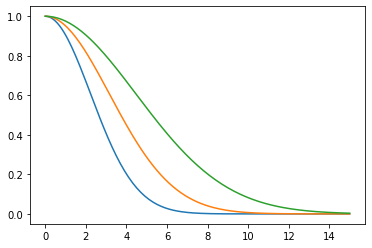

In [8]:
rsf1 = np.array([radialSF(i, 0.1) for i in distances])
rsf2 = np.array([radialSF(i, 0.05) for i in distances])
rsf3 = np.array([radialSF(i, 0.025) for i in distances])
plt.plot(distances, rsf1[:,1], label='')
plt.plot(distances, rsf2[:,1], label='')
plt.plot(distances, rsf3[:,1], label='')
#plt.legend()

### The Angular Symmetry Functions

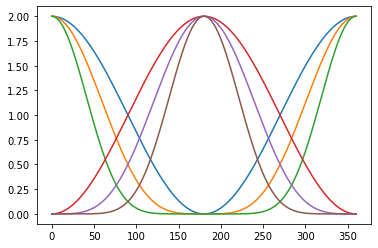

In [9]:
angles = range(0,361)
asf1 = np.array([angularSF(i,1,1,1,1.0,1.0,1.0) for i in angles])
asf2 = np.array([angularSF(i,1,1,1,1.0,1.0,2.0) for i in angles])
asf3 = np.array([angularSF(i,1,1,1,1.0,1.0,4.0) for i in angles])
asf4 = np.array([angularSF(i,1,1,1,1.0,-1.0,1.0) for i in angles])
asf5 = np.array([angularSF(i,1,1,1,1.0,-1.0,2.0) for i in angles])
asf6 = np.array([angularSF(i,1,1,1,1.0,-1.0,4.0) for i in angles])
plt.plot(angles, asf1[:,1])
plt.plot(angles, asf2[:,1])
plt.plot(angles, asf3[:,1])
plt.plot(angles, asf4[:,1])
plt.plot(angles, asf5[:,1])
plt.plot(angles, asf6[:,1])

## RuNNer Mode 2
- the actual fitting
- show mode 2 input
- also include pyiron-RuNNer

### Fitting the Data Set
- definition of NN architecture (~ 2 hidden layers with 10 to 20 nodes)
- run RuNNer mode2 to fit the NN parameters
- run a few fits with different random seeds to avoid bad starting parameters
- have a look on RMSE values (RMSE E ~ 1 meV/atom and F ~ 100 meV/bohr)

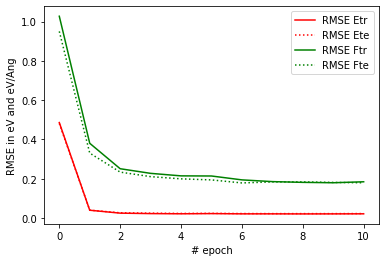

In [20]:
# Load here an example fit
# Use results of the workshop participants
fit2 = RuNFit('MH-df4-2', 7)
figRMSE = fit2.plot_rmse()

### Analysis of the Fit
- energy
- forces

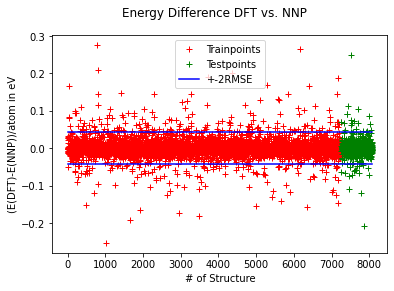

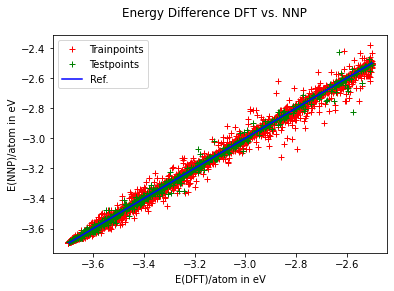

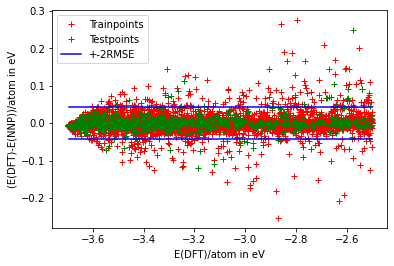

In [17]:
figE1, figE2, figF3 = fit2.plot_points()

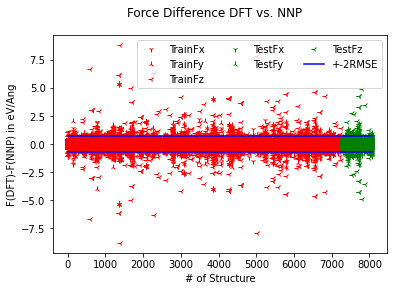

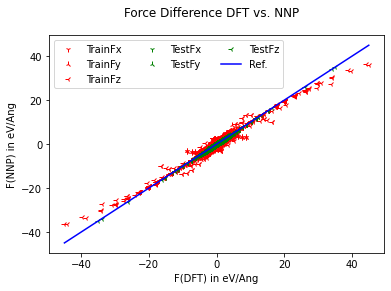

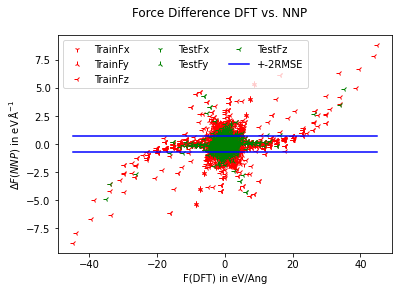

In [16]:
figF1, figF2, figF3 = fit2.plot_forces()

## RuNNer Mode 3
- first testing of the fit possible
- not done here -> day 3

### First Simple Tests for the NNP
- E-V Plot
- EOS-Fitting (lattice constant, bulk-modulus)
- Runtime in MD simulations
- if needed expansion of the data set